In [144]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_model_optimization as tfmot

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
print(train_images.shape)
print(train_labels.shape)
train_images = train_images / 255.0
test_images = test_images / 255.0

(60000, 28, 28)
(60000,)


In [145]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 5, input_shape = (28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2),
    tf.keras.layers.Conv2D(64, 5),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2),
    tf.keras.layers.Conv2D(96, 3),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = 'softmax')
])
model.compile(optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 re_lu_9 (ReLU)              (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          51264     
                                                                 
 re_lu_10 (ReLU)             (None, 8, 8, 64)          0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                 

In [146]:
for i in range(len(model.layers)):
    # for j in range(len(q_aware_model.layers[i].get_weights())):
    print("Layer : ", i, model.layers[i].name, len(model.layers[i].get_weights()))#, len(q_aware_model.layers[i]), "Weights len")


Layer :  0 conv2d_9 2
Layer :  1 re_lu_9 0
Layer :  2 max_pooling2d_9 0
Layer :  3 conv2d_10 2
Layer :  4 re_lu_10 0
Layer :  5 max_pooling2d_10 0
Layer :  6 conv2d_11 2
Layer :  7 re_lu_11 0
Layer :  8 max_pooling2d_11 0
Layer :  9 flatten_3 0
Layer :  10 dense_3 2


In [148]:
loss, acc = model.evaluate(test_images, test_labels)
print('Test accuracy : ', "{:0.2%}".format(acc))

313/313 [==============================] - 2s 5ms/step - loss: 2.2966 - accuracy: 0.1053
Test accuracy :  10.53%


In [149]:
train_log = model.fit(train_images, train_labels,
    batch_size = 64,
    epochs = 15,
    validation_split = 0.1)

Epoch 1/15
844/844 [==============================] - 22s 25ms/step - loss: 0.5776 - accuracy: 0.7898 - val_loss: 0.4004 - val_accuracy: 0.8520
Epoch 2/15
844/844 [==============================] - 20s 23ms/step - loss: 0.3541 - accuracy: 0.8722 - val_loss: 0.3278 - val_accuracy: 0.8832
Epoch 3/15
844/844 [==============================] - 20s 24ms/step - loss: 0.3000 - accuracy: 0.8912 - val_loss: 0.3273 - val_accuracy: 0.8903
Epoch 4/15
844/844 [==============================] - 19s 22ms/step - loss: 0.2689 - accuracy: 0.9026 - val_loss: 0.2790 - val_accuracy: 0.9010
Epoch 5/15
844/844 [==============================] - 20s 24ms/step - loss: 0.2459 - accuracy: 0.9106 - val_loss: 0.2672 - val_accuracy: 0.9067
Epoch 6/15
844/844 [==============================] - 19s 23ms/step - loss: 0.2272 - accuracy: 0.9165 - val_loss: 0.2667 - val_accuracy: 0.9098
Epoch 7/15
844/844 [==============================] - 20s 24ms/step - loss: 0.2099 - accuracy: 0.9230 - val_loss: 0.2559 - val_accuracy:

In [150]:
loss, acc = model.evaluate(test_images, test_labels)
print('Test accuracy : ', "{:0.2%}".format(acc))

313/313 [==============================] - 1s 4ms/step - loss: 0.2928 - accuracy: 0.9080
Test accuracy :  90.80%


In [151]:
save_dir = "./logs/"
save_path = save_dir + "model_v2"
model.save(save_path)

INFO:tensorflow:Assets written to: ./logs/model_v2\assets


INFO:tensorflow:Assets written to: ./logs/model_v2\assets


In [152]:
# Load model_v2
save_dir = "./logs/"
save_path = save_dir + "model_v2"
# model = tf.keras.models.load_model(save_path)
loss, acc = model.evaluate(test_images, test_labels)
print('Test accuracy : ', "{:0.2%}".format(acc))

313/313 [==============================] - 2s 5ms/step - loss: 0.2928 - accuracy: 0.9080
Test accuracy :  90.80%


In [156]:
quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)

In [157]:
q_aware_model.compile(optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['accuracy'])
q_aware_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_2 (QuantizeL  (None, 28, 28, 1)        3         
 ayer)                                                           
                                                                 
 quant_conv2d_9 (QuantizeWra  (None, 24, 24, 32)       833       
 pperV2)                                                         
                                                                 
 quant_re_lu_9 (QuantizeWrap  (None, 24, 24, 32)       3         
 perV2)                                                          
                                                                 
 quant_max_pooling2d_9 (Quan  (None, 12, 12, 32)       1         
 tizeWrapperV2)                                                  
                                                                 
 quant_conv2d_10 (QuantizeWr  (None, 8, 8, 64)        

In [158]:
train_log = q_aware_model.fit(train_images, train_labels,
    batch_size = 128,
    # epochs = 15,
    epochs = 1,
    validation_split = 0.1)

422/422 [==============================] - 23s 51ms/step - loss: 0.0953 - accuracy: 0.9667 - val_loss: 0.2705 - val_accuracy: 0.9158


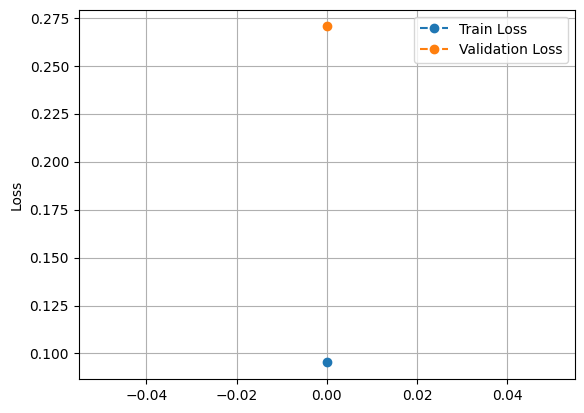

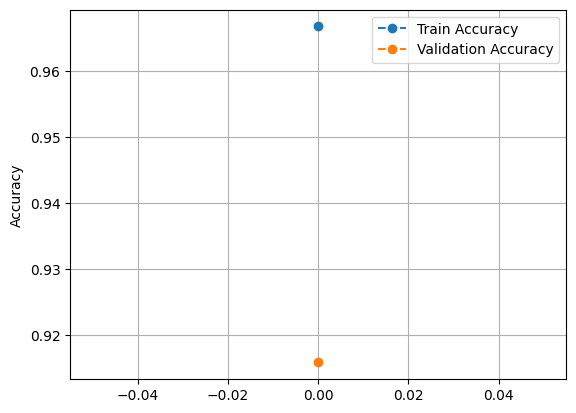

In [159]:
fig = plt.figure()
plt.plot(train_log.history['loss'], label = 'Train Loss', linestyle = '--', marker = 'o')
plt.plot(train_log.history['val_loss'], label = 'Validation Loss', linestyle = '--', marker = 'o')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

fig = plt.figure()
plt.plot(train_log.history['accuracy'], label = 'Train Accuracy', linestyle = '--', marker = 'o')
plt.plot(train_log.history['val_accuracy'], label = 'Validation Accuracy', linestyle = '--', marker = 'o')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [160]:
q_aware_test_loss, q_aware_test_acc = q_aware_model.evaluate(test_images, test_labels)
print('Test accuracy : ', "{:0.2%}".format(q_aware_test_acc))

313/313 [==============================] - 2s 5ms/step - loss: 0.2991 - accuracy: 0.9113
Test accuracy :  91.13%


In [161]:
# Save quantized model
save_dir = "./logs/"
save_path = save_dir + "model_q2"
# q_aware_model.save(save_path)

INFO:tensorflow:Assets written to: ./logs/model_q2\assets


INFO:tensorflow:Assets written to: ./logs/model_q2\assets


In [162]:
# Load model 
save_dir = "./logs/"
save_path = save_dir + "model_q2"
# q_aware_model = tf.keras.models.load_model(save_path)
q_aware_test_loss, q_aware_test_acc = q_aware_model.evaluate(test_images, test_labels)
print('Test accuracy : ', "{:0.2%}".format(q_aware_test_acc))

313/313 [==============================] - 2s 6ms/step - loss: 0.2991 - accuracy: 0.9113
Test accuracy :  91.13%


In [163]:
for i in range(len(q_aware_model.layers)):
    # for j in range(len(q_aware_model.layers[i].get_weights())):
    print("Layer : ", i, q_aware_model.layers[i].name,"params ", len(q_aware_model.layers[i].get_weights()))#, len(q_aware_model.layers[i]), "Weights len")

# print(q_aware_model.layers[3].get_weights())

Layer :  0 quantize_layer_2 params  3
Layer :  1 quant_conv2d_9 params  3
Layer :  2 quant_re_lu_9 params  3
Layer :  3 quant_max_pooling2d_9 params  1
Layer :  4 quant_conv2d_10 params  3
Layer :  5 quant_re_lu_10 params  3
Layer :  6 quant_max_pooling2d_10 params  1
Layer :  7 quant_conv2d_11 params  3
Layer :  8 quant_re_lu_11 params  3
Layer :  9 quant_max_pooling2d_11 params  1
Layer :  10 quant_flatten_3 params  1
Layer :  11 quant_dense_3 params  7


In [227]:
# for i in range(len(q_aware_model.layers)):
#     print("Layer : ", i)
    # print(q_aware_model.layers[i].get_weights())#.__dict__)
print(q_aware_model.layers[2].get_weights())#.__dict__)


[-1, -3.9335735, 4.541597]


In [213]:
lay = 0 + 1
for lay in range(len(q_aware_model.layers)):
    for j in range(len(q_aware_model.layers[lay].get_weights())):
        print("Layer : ", i, q_aware_model.layers[lay].name,"params ", q_aware_model.layers[lay].get_weights()[j])#, len(q_aware_model.layers[i]), "Weights len")


Layer :  11 quantize_layer_2 params  0.0
Layer :  11 quantize_layer_2 params  1.0
Layer :  11 quantize_layer_2 params  -1
Layer :  11 quant_conv2d_9 params  [[[[-1.32011436e-02 -1.57563128e-02  8.21516141e-02 -2.50107720e-02
    -1.20837808e-01 -3.21510360e-02 -2.96397302e-02 -1.10338442e-01
    -2.19383556e-02 -1.22325365e-02  7.03390613e-02  3.45139019e-02
    -2.96316743e-02  6.47405162e-02  1.58913627e-01  1.37490720e-01
     5.73403714e-03  8.78975019e-02  1.33331120e-01  5.89454584e-02
    -2.41066083e-01  3.58705819e-02  4.69711497e-02  1.03790320e-01
    -5.07060736e-02 -7.03536645e-02  3.90717760e-02 -1.95529506e-01
    -4.37117219e-01 -2.81913336e-02  5.89329898e-02 -2.46334318e-02]]

  [[ 8.95907544e-03 -8.14672559e-02  2.62994438e-01 -5.62564395e-02
    -8.17236751e-02  2.01565579e-01  3.10274828e-02 -3.70605946e-01
     1.10150121e-01 -1.33407861e-01  3.82178314e-02  5.23603298e-02
     3.92925180e-02 -9.32911560e-02 -3.36464420e-02 -3.54562961e-02
    -8.86621885e-03  6.3

In [167]:
for i, layer in enumerate(q_aware_model.layers):
    # print(len(layer.__dict__))
    # print(vars(layer))
    # print("########################################################")
    print(i)
    # print("########################################################")
    # if i == 1:
    for elem in layer.__dict__:
        # print(elem)
        # if elem ==  '_config':
        #     # print(True)
        #     # print(layer.__dict__['_config'])
        #     for conf in layer.__dict__['_config']:
        #         if conf == 'quantize_config':
        #             print(True)
        if elem == '_weight_vars':
            # if(len(layer._weight_vars)) != 0:
            #     print(len(layer._weight_vars))
            print(layer._weight_vars)
    # if hasattr(layer, '_weight_vars'):
    #     print(True)
        # for weight, quantizer, quantizer_vars in layer._weight_vars:
            # quantized_and_dequantized = quantizer(weight, training = False, weights = quantizer_vars)
            # print(quantized_and_dequantized)
            # min_var = quantizer_vars['min_var']
            # max_var = quantizer_vars['max_var']
            # quantized = dequantize(quantize_and_dequantized, min_var, max_var, quantizer)

0
1
ListWrapper([])
2
ListWrapper([])
3
ListWrapper([])
4
ListWrapper([])
5
ListWrapper([])
6
ListWrapper([])
7
ListWrapper([])
8
ListWrapper([])
9
ListWrapper([])
10
ListWrapper([])
11
ListWrapper([_TupleWrapper((<tf.Variable 'dense_3/kernel:0' shape=(96, 10) dtype=float32, numpy=
array([[ 3.03513050e-01, -5.78877330e-01, -2.08118409e-01,
        -4.34350669e-01, -3.72206032e-01, -5.18794954e-02,
        -6.38450325e-01, -7.79150501e-02, -2.76653647e-01,
         3.08603495e-01],
       [ 2.01251313e-01, -4.03820910e-02,  1.91630423e-01,
        -2.21828267e-01, -2.16631666e-01, -9.05057508e-03,
        -2.24734023e-01, -1.74681112e-01,  8.53608102e-02,
         1.49648013e-02],
       [-5.44459701e-01,  6.09009080e-02, -1.47468746e-01,
         1.11299276e-01,  1.95920125e-01,  2.13097155e-01,
         1.45261154e-01, -3.68728712e-02, -2.10609421e-01,
         5.78800291e-02],
       [ 2.39981756e-01,  5.03890999e-02,  5.84280789e-02,
        -4.06140119e-01,  2.15543479e-01, -3.1834

In [243]:
bit_width = 8
for i, layer in enumerate(q_aware_model.layers):
    if hasattr(layer, '_weight_vars'):
        for weight, quantizer, quantizer_vars in layer._weight_vars:
            quantized_and_dequantized = quantizer(weight, training = False, weights = quantizer_vars)
            # print(quantized_and_dequantized)
            print(True)
            min_var = quantizer_vars['min_var']
            max_var = quantizer_vars['max_var']
            # quantized = dequantize(quantize_and_dequantized, min_var, max_var, quantizer)
            quantized = np.round(quantized_and_dequantized / max_var * (2**(bit_width-1)-1))
print(len(quantized))

# print(quantized[:20])
# print(quantized[80:])

True
96


In [254]:
lay = 0
print(q_aware_model.layers[lay].name)
print(q_aware_model.layers[lay].get_weights())
# q_aware_model.layers[3]._weight_vars
# q_aware_model.layers[3].name

quant_max_pooling2d_9
[-1]


In [242]:
print(quantized[80:])

[[   7.  -51.   10.  -59.  -30.   40.   13.  -58.    7.  -33.]
 [  20.  -94.    8.  -69.   35.   26.  -60.  -22.  -76.  -53.]
 [  26. -107.    3.  -35.   52.  -49.   -5.  -26.  -54.  -52.]
 [ -27.  -94.  -17.   29.  -68.   24.   34.  -25.  -29.    9.]
 [  -8.  -56.   39.  -78.   -1.   23.  -43.   -6.   59.   11.]
 [  12.   15.  -25.  -14.  -18.   27.  -13.   -9.   -9.   11.]
 [  26.   -4.   23.   15.  -28.  -33.   21.   16.   -4.    5.]
 [  -5.  -21.  -18.    1.  -16.  -58.  -20.   14.    9.    8.]
 [  24.  -55.  -41.   -3.  -22.  -92.   57.  -11.   35.  -27.]
 [ -11.  -94.  -61.  -78.   24.  -78.  -22.  -19.   67.  -30.]
 [  26.   51.  -63.   33.  -14.    0.   -1.   35.   32.   12.]
 [  -9.   -4.  -16.   23.   39.  -40.   22.  -59.  -87.   46.]
 [ -39.   -6.  -22.    4.   23.  -13.    9.   32.  -14.   25.]
 [  30.    0.  -40.  -15.  -50.   29.  -43.   40.   35.   18.]
 [   9. -110.   -2.  -61.  -39.   55.  -31.  -14.   21.  -56.]
 [ -15.    0.  -18.  -26.   29.  -14.  -21.    6.  -19.

'2.11.0'

In [32]:
# q_layers = q_aware_model.layers
# # print(model.layers)
# # print(q_aware_model.layers)
# bit_width = 8
# weight, quantizer, quantizer_vars = q_layers[2]._weight_vars[0]
# quantized_and_dequantized = quantizer(weight, training = False, weights = quantizer_vars)
# min_var = quantizer_vars['min_var']
# max_var = quantizer_vars['max_var']
# quantized = np.round(quantized_and_dequantized / max_var * (2**(bit_width-1)-1))
# # print(q_layers[2]._weight_vars[0])

IndexError: list index out of range

In [186]:
# Conversion to TF Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\rosal\AppData\Local\Temp\tmpktu_onrx\assets


INFO:tensorflow:Assets written to: C:\Users\rosal\AppData\Local\Temp\tmpktu_onrx\assets
c:\Users\rosal\py_master_project\lib\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [187]:
def evaluate_model(interpreter: tf.lite.Interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    # print("Shape : ", test_image.shape)
    test_image = np.expand_dims(test_image, axis = 0).astype(np.float32)
    test_image = np.expand_dims(test_image, axis = 3).astype(np.float32)
    # print("New Shape : ", test_image.shape)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  return accuracy

In [188]:
interpreter = tf.lite.Interpreter(model_content = quantized_tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape: ", input_details[0]['shape'])
print("Output Shape: ", output_details[0]['shape'])

test_accuracy = evaluate_model(interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)
print('Quant TF test accuracy:', q_aware_test_acc)

Input Shape:  [ 1 28 28  1]
Output Shape:  [ 1 10]
Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Quant TFLite test_accuracy: 0.9116
Quant TF test accuracy: 0.911300003528595


In [189]:
save_dir = "./logs/"
quant_file = 'quant_model_q2.tflite'
save_path = save_dir + quant_file
with open(save_path, 'wb') as f:
  f.write(quantized_tflite_model)

In [190]:
for i, layer in enumerate(q_aware_model.layers):
    print(layer.name, len(layer.get_weights()))
    for j in range(len(layer.get_weights())):
        # print(layer.get_weights()[j].shape)
        pass
print(q_aware_model.layers[2].get_weights()[0])

quantize_layer_2 3
quant_conv2d_9 3
quant_re_lu_9 3
quant_max_pooling2d_9 1
quant_conv2d_10 3
quant_re_lu_10 3
quant_max_pooling2d_10 1
quant_conv2d_11 3
quant_re_lu_11 3
quant_max_pooling2d_11 1
quant_flatten_3 1
quant_dense_3 7
-1


In [15]:
ind_index = 10
test_image = test_images[ind_index]
test_image = np.expand_dims(test_image, axis = 0).astype(np.float32)
test_image = np.expand_dims(test_image, axis = 3).astype(np.float32)

interpreter.set_tensor(input_details[0]['index'], test_image)
interpreter.invoke()
output_array = interpreter.get_tensor(output_details[0]['index'])
# print(output_array.shape)
digit = np.argmax(output_array[0])
probability = max(output_array[0])
print("Input index : ", test_labels[ind_index])
print("Output index : ", digit, "{0:.2%}".format(probability))


Input index :  4
Output index :  4 99.61%


In [16]:
# # interpreter.allocate_tensors()
# tensor_details = interpreter.get_tensor_details()

# for dict in tensor_details: 
#     i = dict['index']
#     tensor_name = dict['name']
#     scales = dict['quantization_parameters']['scales']
#     zero_points = dict['quantization_parameters']['zero_points']
#     tensor = interpreter.tensor(i)()
    
#     print(i, tensor_name, scales.shape, zero_points.shape, tensor.shape)

0 serving_default_conv2d_input:0 (0,) (0,) (1, 28, 28, 1)
1 sequential/quant_flatten/Const (0,) (0,) (2,)
2 sequential/quant_conv2d/BiasAdd/ReadVariableOp (32,) (32,) (32,)
3 sequential/quant_conv2d_1/BiasAdd/ReadVariableOp (64,) (64,) (64,)
4 sequential/quant_conv2d_2/BiasAdd/ReadVariableOp (96,) (96,) (96,)
5 sequential/quant_conv2d/Conv2D (32,) (32,) (32, 5, 5, 1)
6 sequential/quant_conv2d_1/Conv2D (64,) (64,) (64, 5, 5, 32)
7 sequential/quant_conv2d_2/Conv2D (96,) (96,) (96, 3, 3, 64)
8 sequential/quant_dense/BiasAdd/ReadVariableOp (1,) (1,) (10,)


ValueError: Tensor data is null. Run allocate_tensors() first